**Imports**

In [1]:
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential,Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import spacy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel

from kerastuner.tuners import GridSearch

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gayathrisjs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gayathrisjs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/8n/_zjkyv9n797_9m5r9rhdczvc0000gn/T/ipykernel_21347/2555665412.py:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import GridSearch


In [2]:
def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary



In [3]:
data = pd.read_csv('24_train.csv')
test = pd.read_csv('news-test.csv')
dictionary = get_dict("dictionary.txt")
result=[]

**One Hot Encoding of Category column**

In [4]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(data['Category'])
print(y_train_encoded[2])
# Now, convert the integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=5)


3


**Count Vectorizer**

In [5]:
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2),vocabulary=dictionary)
feature = ngram_vectorizer.fit_transform(data['Text']).toarray()
data['CountVector'] = list(feature)
test['CountVector'] = list(ngram_vectorizer.fit_transform(test['Text']).toarray())

In [6]:
ngram_vectorizer.fit_transform(test['Text']).toarray().shape

(735, 1000)

In [7]:
len(ngram_vectorizer.get_feature_names_out())

1000

**Training and Validating Neural Network**

Create and train a neural network with 2 hidden layers and validate it using 5 fold validation. Store the accuraries in result.

In [8]:

# Assuming X_ngrams is the input feature matrix and labels are in 'Category' column
# X_train, X_val, y_train, y_val = train_test_split(X_ngrams,y_train_one_hot, test_size=0.2, random_state=42)

def createModel(feature):
    input_text = Input(shape=(feature.shape[1],))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(5, activation='softmax')(hidden2)
    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Train_acc_countvector=[]
Val_acc_countvector=[]
cv = KFold(n_splits=5, shuffle=True, random_state = 42)
for train_index, val_index in cv.split(feature):
    X_train, X_val = feature[train_index], feature[val_index]
    y_train, y_val = y_train_one_hot[train_index], y_train_one_hot[val_index]
    model = createModel(feature)
    model_result = model.fit(X_train, y_train, epochs = 10)
    train_acc = model_result.history['accuracy'][-1]
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    Train_acc_countvector.append(train_acc)
    Val_acc_countvector.append(val_accuracy)



Epoch 1/10
25/25 [==============================] - 0s 612us/step - loss: 1.1471 - accuracy: 0.6363
Epoch 2/10
25/25 [==============================] - 0s 622us/step - loss: 0.3053 - accuracy: 0.9588
Epoch 3/10
25/25 [==============================] - 0s 645us/step - loss: 0.0839 - accuracy: 0.9887
Epoch 4/10
25/25 [==============================] - 0s 607us/step - loss: 0.0292 - accuracy: 0.9987
Epoch 5/10
25/25 [==============================] - 0s 720us/step - loss: 0.0136 - accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 0s 614us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 0s 659us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 0s 644us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 0s 624us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 0s 665us/step - loss: 0.1822 - accuracy: 0.9400
E

In [9]:

result.append({
    'Feature': "CountVector",
    'Avg_Train_Acc': np.mean(Train_acc_countvector),
    'Avg_Val_Acc': np.mean(Val_acc_countvector),
    'Std_Train_Acc': np.std(Train_acc_countvector),
    'Std_Val_Acc': np.std(Val_acc_countvector)
})

**TFI-DF Vectorizer**

In [10]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=dictionary)

# Fit and transform the text data
tfidf_features = tfidf_vectorizer.fit_transform(data['Text'])

# Convert the sparse matrix to a dense array
feature = tfidf_features.toarray()

data['TFIDF'] = list(feature)
test['TFIDF'] = list( tfidf_vectorizer.fit_transform(test['Text']).toarray())

**Training and Validating Neural Network**

Create and train a neural network with 2 hidden layers and validate it using 5 fold validation. Store the accuraries in result.

In [11]:
def createModel(feature):
    input_text = Input(shape=(feature.shape[1],))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(5, activation='softmax')(hidden2)
    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Train_acc_tfidf=[]
Val_acc_tfidf=[]
cv = KFold(n_splits=5, shuffle=True, random_state = 42)
for train_index, val_index in cv.split(feature):
    X_train, X_val = feature[train_index], feature[val_index]
    y_train, y_val = y_train_one_hot[train_index], y_train_one_hot[val_index]
    model = createModel(feature)
    model_result = model.fit(X_train, y_train, epochs = 10)
    train_acc = model_result.history['accuracy'][-1]
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    Train_acc_tfidf.append(train_acc)
    Val_acc_tfidf.append(val_accuracy)



Epoch 1/10
25/25 [==============================] - 0s 605us/step - loss: 1.5485 - accuracy: 0.4500
Epoch 2/10
25/25 [==============================] - 0s 653us/step - loss: 1.0877 - accuracy: 0.8512
Epoch 3/10
25/25 [==============================] - 0s 626us/step - loss: 0.3816 - accuracy: 0.9575
Epoch 4/10
25/25 [==============================] - 0s 614us/step - loss: 0.1180 - accuracy: 0.9850
Epoch 5/10
25/25 [==============================] - 0s 627us/step - loss: 0.0520 - accuracy: 0.9962
Epoch 6/10
25/25 [==============================] - 0s 634us/step - loss: 0.0273 - accuracy: 0.9975
Epoch 7/10
25/25 [==============================] - 0s 643us/step - loss: 0.0170 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 0s 658us/step - loss: 0.0107 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 0s 651us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 0s 551us/step - loss: 0.1372 - accuracy: 0.9350
E

In [12]:

result.append({
    'Feature': "TFIDF",
    'Avg_Train_Acc': np.mean(Train_acc_tfidf),
    'Avg_Val_Acc': np.mean(Val_acc_tfidf),
    'Std_Train_Acc': np.std(Train_acc_tfidf),
    'Std_Val_Acc': np.std(Val_acc_tfidf)
})

**GloVe**

**Training and Validating Neural Network**

Create and train a neural network with 2 hidden layers and validate it using 5 fold validation. Store the accuraries in result.

In [13]:

# Load spaCy model with GloVe embeddings
nlp = spacy.load("en_core_web_md")


# Function to calculate document vector using spaCy and GloVe
def calculate_doc_vector(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    # Return the document vector (average of word vectors)
    return doc.vector

# Apply the function to create a new column 'doc_vector'
data['GloVe'] = data['Text'].apply(calculate_doc_vector)
test['GloVe'] = test['Text'].apply(calculate_doc_vector)
feature=np.array(data['GloVe'].tolist())
y=np.array(y_train_one_hot.tolist())

def createModel(feature):
    input_text = Input(shape=(feature.shape[1],))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(5, activation='softmax')(hidden2)
    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Train_acc_glove=[]
Val_acc_glove=[]
cv = KFold(n_splits=5, shuffle=True, random_state = 42)
for train_index, val_index in cv.split(feature):
    X_train, X_val = feature[train_index], feature[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = createModel(feature)
    model_result = model.fit(X_train, y_train, epochs = 10)
    train_acc = model_result.history['accuracy'][-1]
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    Train_acc_glove.append(train_acc)
    Val_acc_glove.append(val_accuracy)


Epoch 1/10
25/25 [==============================] - 0s 564us/step - loss: 1.1153 - accuracy: 0.5900
Epoch 2/10
25/25 [==============================] - 0s 601us/step - loss: 0.5119 - accuracy: 0.8225
Epoch 3/10
25/25 [==============================] - 0s 434us/step - loss: 0.3528 - accuracy: 0.8888
Epoch 4/10
25/25 [==============================] - 0s 447us/step - loss: 0.2732 - accuracy: 0.9038
Epoch 5/10
25/25 [==============================] - 0s 449us/step - loss: 0.2756 - accuracy: 0.9038
Epoch 6/10
25/25 [==============================] - 0s 475us/step - loss: 0.2110 - accuracy: 0.9287
Epoch 7/10
25/25 [==============================] - 0s 479us/step - loss: 0.1824 - accuracy: 0.9362
Epoch 8/10
25/25 [==============================] - 0s 481us/step - loss: 0.1983 - accuracy: 0.9350
Epoch 9/10
25/25 [==============================] - 0s 466us/step - loss: 0.1688 - accuracy: 0.9337
Epoch 10/10
7/7 [==============================] - 0s 522us/step - loss: 0.1766 - accuracy: 0.9500
E

In [14]:

result.append({
    'Feature': "GloVe",
    'Avg_Train_Acc': np.mean(Train_acc_glove),
    'Avg_Val_Acc': np.mean(Val_acc_glove),
    'Std_Train_Acc': np.std(Train_acc_glove),
    'Std_Val_Acc': np.std(Val_acc_glove)
})

**BERT**

In [15]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to extract BERT embeddings for a given text
def get_bert_embeddings(text):
    # Tokenize and pad sequences to a maximum length
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].numpy()

# Apply the function to the 'text' column and create a new column 'bert_embeddings'
data['BERT'] = data['Text'].apply(get_bert_embeddings)
test['BERT'] = test['Text'].apply(get_bert_embeddings)
print(data)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


     ArticleId                                               Text  \
0         1429  sfa awaits report over mikoliunas the scottish...   
1         1896  parmalat to return to stockmarket parmalat  th...   
2         1633  edu blasts arsenal arsenal s brazilian midfiel...   
3         2178  henman decides to quit davis cup tim henman ha...   
4          194  french suitor holds lse meeting european stock...   
..         ...                                                ...   
995       1250  blair  damaged  by blunkett row a majority of ...   
996       1639  a november to remember last saturday  one news...   
997        916  highbury tunnel players in clear the football ...   
998       2217  top stars join us tsunami tv show brad pitt  r...   
999        902  eastwood s baby scoops top oscars clint eastwo...   

          Category                                        CountVector  \
0            sport  [1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
1         business  [0, 0

**Training and Validating Neural Network**

Create and train a neural network with 2 hidden layers and validate it using 5 fold validation. Store the accuraries in result.

In [16]:


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num_classes=5
def createModel(feature):
    input_text = Input(shape=(feature.shape[1],))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(num_classes, activation='softmax')(hidden2)
    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


feature=np.concatenate(data['BERT'].values)
cv = KFold(n_splits=5, shuffle=True, random_state = 42)
Train_acc_bert=[]
Val_acc_bert=[]
for train_index, val_index in cv.split(feature):
    X_train, X_val = feature[train_index], feature[val_index]
    y_train, y_val = y_train_one_hot[train_index], y_train_one_hot[val_index]
    model = createModel(feature)
    model_result = model.fit(X_train, y_train, epochs = 10)
    train_acc = model_result.history['accuracy'][-1]
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    Train_acc_bert.append(train_acc)
    Val_acc_bert.append(val_accuracy)



Epoch 1/10
25/25 [==============================] - 0s 649us/step - loss: 0.7335 - accuracy: 0.7812
Epoch 2/10
25/25 [==============================] - 0s 457us/step - loss: 0.1747 - accuracy: 0.9500
Epoch 3/10
25/25 [==============================] - 0s 472us/step - loss: 0.1065 - accuracy: 0.9663
Epoch 4/10
25/25 [==============================] - 0s 473us/step - loss: 0.0750 - accuracy: 0.9775
Epoch 5/10
25/25 [==============================] - 0s 483us/step - loss: 0.0440 - accuracy: 0.9887
Epoch 6/10
25/25 [==============================] - 0s 494us/step - loss: 0.0218 - accuracy: 0.9975
Epoch 7/10
25/25 [==============================] - 0s 531us/step - loss: 0.0153 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 0s 479us/step - loss: 0.0116 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 0s 543us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 0s 624us/step - loss: 0.0823 - accuracy: 0.9700
E

In [17]:

result.append({
    'Feature': "BERT",
    'Avg_Train_Acc': np.mean(Train_acc_bert),
    'Avg_Val_Acc': np.mean(Val_acc_bert),
    'Std_Train_Acc': np.std(Train_acc_bert),
    'Std_Val_Acc': np.std(Val_acc_bert)
})

**Covert result to a dataframe to print the accuracies in a tabular format**

In [18]:
result_df = pd.DataFrame(result)
print(result_df)

       Feature  Avg_Train_Acc  Avg_Val_Acc  Std_Train_Acc  Std_Val_Acc
0  CountVector         1.0000        0.946       0.000000     0.005831
1        TFIDF         1.0000        0.951       0.000000     0.014629
2        GloVe         0.9525        0.937       0.013038     0.018601
3         BERT         1.0000        0.968       0.000000     0.005099


**Plot a Graph to compare Training and Validation Accuracies for different models**

In [19]:
train_acc = result_df['Avg_Train_Acc'].tolist()
train_acc

[1.0, 1.0, 0.9524999976158142, 1.0]

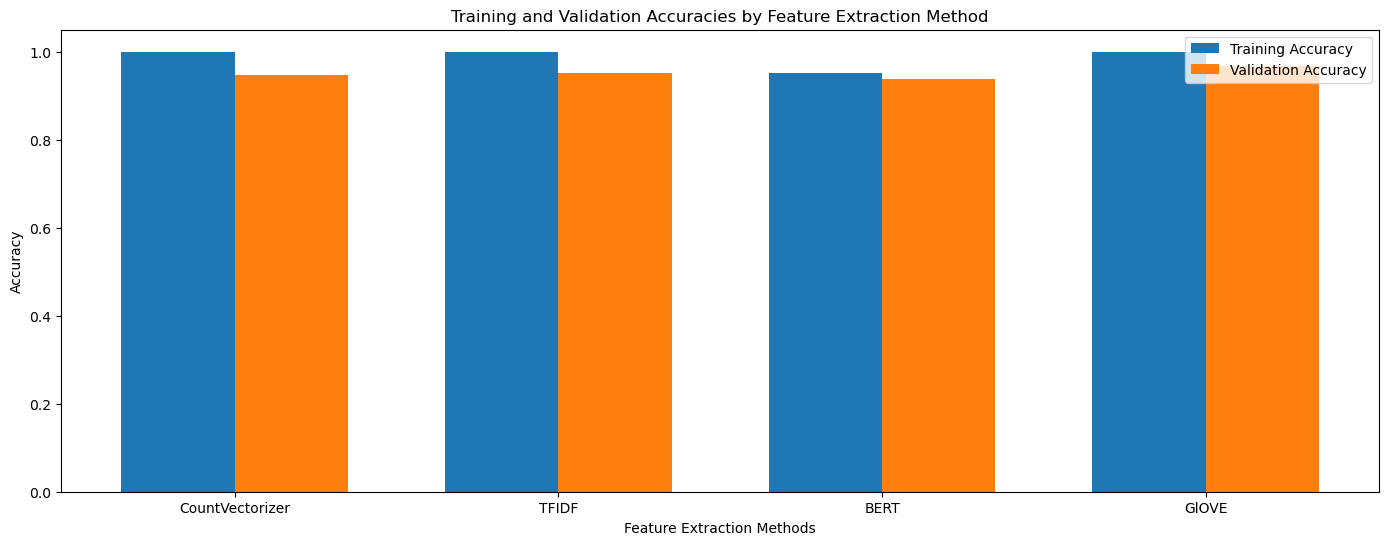

In [20]:

parameters = ['CountVectorizer', 'TFIDF', 'BERT', 'GlOVE']
train_acc = result_df['Avg_Train_Acc'].tolist()
val_acc = result_df['Avg_Val_Acc'].tolist()
# train_acc = [np.mean(Train_acc_count), np.mean(Train_acc_tfidf),np.mean(Train_acc_bert), np.mean(Train_acc_Glove)]
# val_acc = [np.mean(Val_acc_count), np.mean(Val_acc_tfidf),np.mean(Val_acc_bert), np.mean(Val_acc_Glove)]

width = 0.35
x = np.arange(len(parameters))
fig, ax = plt.subplots(figsize=(17, 6))
ax.bar(x - width/2, train_acc, width, label='Training Accuracy')
ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')
ax.set_xlabel('Feature Extraction Methods')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracies by Feature Extraction Method')
ax.set_xticks(x)
ax.set_xticklabels(parameters)
ax.legend()
plt.show()

In [21]:
data

,ArticleId,Text,Category,CountVector,TFIDF,GloVe,BERT
0,1429,sfa awaits report over mikoliunas the scottish...,sport,"[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.07068628369211698, 0.0, 0.1559450364871253,...","[-1.504953, 1.0489184, -1.6432881, 0.22146176,...","[[-0.6921596, -0.58670557, 0.24926306, -0.4062..."
1,1896,parmalat to return to stockmarket parmalat th...,business,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.1240405633521785, 0.0, ...","[-2.4711528, -0.1927695, -2.6111906, 0.7884381...","[[-0.638439, -0.4999063, 0.32632527, 0.0964038..."
2,1633,edu blasts arsenal arsenal s brazilian midfiel...,sport,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.09063007530259953, 0.0, 0.0,...","[-0.9112519, 1.5079144, -2.477887, -0.5450648,...","[[-0.5185157, -0.37947765, 0.07328506, -0.6101..."
3,2178,henman decides to quit davis cup tim henman ha...,sport,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.5437831, 0.8686301, -1.7728345, -0.1992229...","[[-0.76180494, -0.55865103, 0.28042454, -0.487..."
4,194,french suitor holds lse meeting european stock...,business,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.6062019, 1.0062516, -2.461108, 0.18662423,...","[[-1.040333, -0.19826055, -0.01815823, -0.6395..."
...,...,...,...,...,...,...,...
995,1250,blair damaged by blunkett row a majority of ...,politics,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08861114...","[-2.9384747, -0.08198468, -2.1427119, 1.098952...","[[-0.688539, -0.19720563, 0.19999169, -0.76540..."
996,1639,a november to remember last saturday one news...,sport,"[0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.08324011423673809, 0.0, 0.0, 0.04...","[-2.1787052, 0.85770595, -1.7156782, 0.6814034...","[[-0.14743768, -0.23990116, -0.12520984, -0.51..."
997,916,highbury tunnel players in clear the football ...,sport,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.397803, 1.241503, -1.9041436, -0.000832404...","[[-0.70915914, -0.19753301, 0.12053698, -0.546..."
998,2217,top stars join us tsunami tv show brad pitt r...,entertainment,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.06262571138136022, 0.0,...","[-1.8579051, 0.87572575, -2.718928, 0.06106938...","[[-0.25671557, -0.53557885, 0.46061137, 0.0523..."


**Select the model with best accuracies**

In [22]:
values = result_df['Avg_Val_Acc']
print(values)
keys = result_df['Feature']
lis = [(values[i], keys[i]) for i in range(3)]
lis.sort(reverse = True)
ans = lis[0][1]
feature = np.array(data[ans].tolist()) 
feature_test = np.array(test[ans].tolist()) 

0    0.946
1    0.951
2    0.937
3    0.968
Name: Avg_Val_Acc, dtype: float64


In [23]:
ans

'TFIDF'

In [24]:
feature.shape

(1000, 1000)

In [25]:
feature_test.shape

(735, 1000)

**Evaluating and displaying the chosen model's performance w.r.t different learning rates**

In [26]:

num_classes = 5
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

def createModel(input_dim, learning_rate):
    input_text = Input(shape=(input_dim,))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(num_classes, activation='softmax')(hidden2)
    optimizer = Adam(learning_rate=learning_rate)
    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# features = np.concatenate(data['bert'].values)
input_dim = feature.shape[1]
result_lr=[]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for learning_rate in learning_rates:
    Train_acc = []
    Val_acc = []

    for train_index, val_index in cv.split(feature):
        X_train, X_val = feature[train_index], feature[val_index]
        y_train, y_val = y_train_one_hot[train_index], y_train_one_hot[val_index]

        model = createModel(input_dim, learning_rate)
        model_result = model.fit(X_train, y_train, epochs=10, verbose=0)  # Adjust epochs and other hyperparameters as needed
        train_acc = model_result.history['accuracy'][-1]

        val_loss, val_accuracy = model.evaluate(X_val, y_val)

        Train_acc.append(train_acc)
        Val_acc.append(val_accuracy)

    # Print average training and validation accuracy for each learning rate
    avg_train_acc = np.mean(Train_acc)
    avg_val_acc = np.mean(Val_acc)
    result_lr.append({
    'Learning_Rate': learning_rate,
    'Training_Accuracy': np.mean(avg_train_acc),
    'Validation_Accuracy': np.mean(avg_val_acc)
    })



7/7 [==============================] - 0s 567us/step - loss: 1.2328 - accuracy: 0.8600


7/7 [==============================] - 0s 583us/step - loss: 1.2709 - accuracy: 0.8500


7/7 [==============================] - 0s 611us/step - loss: 1.2643 - accuracy: 0.7250


7/7 [==============================] - 0s 613us/step - loss: 1.2092 - accuracy: 0.9000


7/7 [==============================] - 0s 575us/step - loss: 1.2485 - accuracy: 0.8350


7/7 [==============================] - 0s 600us/step - loss: 0.2449 - accuracy: 0.9400


7/7 [==============================] - 0s 608us/step - loss: 0.2797 - accuracy: 0.9450


7/7 [==============================] - 0s 535us/step - loss: 0.2517 - accuracy: 0.9400


7/7 [==============================] - 0s 553us/step - loss: 0.2183 - accuracy: 0.9450


7/7 [==============================] - 0s 687us/step - loss: 0.2325 - accuracy: 0.9500


7/7 [==============================] - 0s 1ms/step - loss: 0.1531 - accuracy: 0.9400


7/7 [==============================] - 0s 588us/step - loss: 0.1772 - accuracy: 0.9300


7/7 [==============================] - 0s 670us/step - loss: 0.1664 - accuracy: 0.9500


7/7 [==============================] - 0s 559us/step - loss: 0.1327 - accuracy: 0.9700


7/7 [==============================] - 0s 543us/step - loss: 0.1539 - accuracy: 0.9700


7/7 [==============================] - 0s 568us/step - loss: 0.1600 - accuracy: 0.9400


7/7 [==============================] - 0s 623us/step - loss: 0.2153 - accuracy: 0.9300


7/7 [==============================] - 0s 533us/step - loss: 0.1877 - accuracy: 0.9350


7/7 [==============================] - 0s 578us/step - loss: 0.1318 - accuracy: 0.9600


7/7 [==============================] - 0s 693us/step - loss: 0.1885 - accuracy: 0.9650


7/7 [==============================] - 0s 576us/step - loss: 0.2343 - accuracy: 0.9350


7/7 [==============================] - 0s 621us/step - loss: 0.2512 - accuracy: 0.9400


7/7 [==============================] - 0s 719us/step - loss: 0.3484 - accuracy: 0.9400


7/7 [==============================] - 0s 530us/step - loss: 0.1878 - accuracy: 0.9450


7/7 [==============================] - 0s 593us/step - loss: 0.2945 - accuracy: 0.9600


7/7 [==============================] - 0s 519us/step - loss: 0.4078 - accuracy: 0.9200


7/7 [==============================] - 0s 617us/step - loss: 0.6258 - accuracy: 0.9150


7/7 [==============================] - 0s 613us/step - loss: 0.5049 - accuracy: 0.9350


7/7 [==============================] - 0s 546us/step - loss: 0.6337 - accuracy: 0.9400


7/7 [==============================] - 0s 545us/step - loss: 0.5913 - accuracy: 0.9150


7/7 [==============================] - 0s 586us/step - loss: 2.7978 - accuracy: 0.9000


7/7 [==============================] - 0s 1ms/step - loss: 1.9800 - accuracy: 0.9150


7/7 [==============================] - 0s 572us/step - loss: 2.1560 - accuracy: 0.8950


7/7 [==============================] - 0s 677us/step - loss: 1.4386 - accuracy: 0.9050


7/7 [==============================] - 0s 592us/step - loss: 1.4653 - accuracy: 0.8250


In [27]:
result_lr_df = pd.DataFrame(result_lr)
print(result_lr_df)

   Learning_Rate  Training_Accuracy  Validation_Accuracy
0         0.0001            0.88425                0.834
1         0.0003            0.98850                0.944
2         0.0010            1.00000                0.952
3         0.0030            1.00000                0.946
4         0.0100            1.00000                0.944
5         0.0300            0.99750                0.925
6         0.1000            0.98100                0.888


**Plot a graph to visualize Training and Validation accuracy trends w.r.t learning rates**

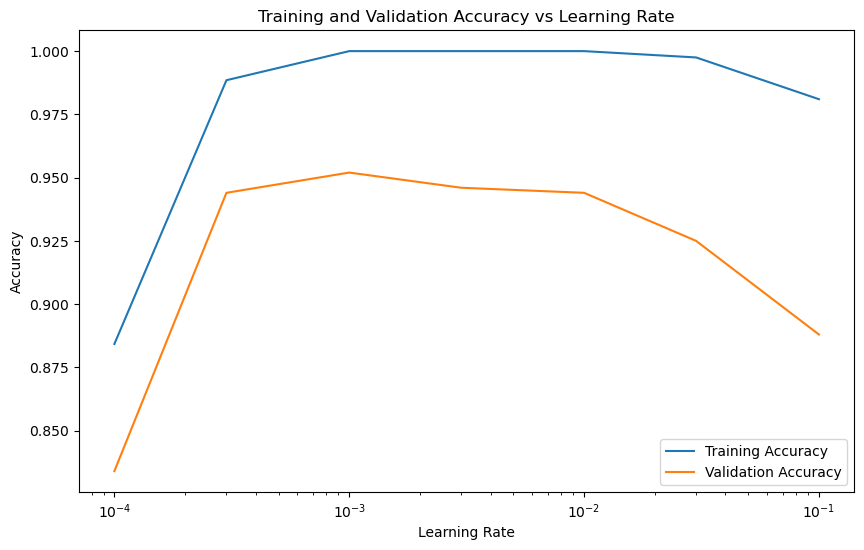

In [28]:


plt.figure(figsize=(10, 6))
plt.plot(result_lr_df['Learning_Rate'], result_lr_df['Training_Accuracy'], label='Training Accuracy')
plt.plot(result_lr_df['Learning_Rate'], result_lr_df['Validation_Accuracy'], label='Validation Accuracy')
plt.xscale('log')  # Use log scale for better visualization
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Learning Rate')
plt.legend()
plt.show()

**Evaluating and displaying the chosen model's performance w.r.t different optimizers**

In [29]:

num_classes = 5
optimizers = ['SGD', 'Adam', 'RMSprop']

def createModel(input_dim, optimizer):
    input_text = Input(shape=(input_dim,))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(num_classes, activation='softmax')(hidden2)
    
    if optimizer == 'SGD':
        optimizer = SGD()
    elif optimizer == 'Adam':
        optimizer = Adam()
    elif optimizer == 'RMSprop':
        optimizer = RMSprop()

    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

result_opt=[]
# features = np.concatenate(data['bert'].values)
input_dim = feature.shape[1]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for optimizer in optimizers:
    Train_acc = []
    Val_acc = []

    for train_index, val_index in cv.split(feature):
        X_train, X_val = feature[train_index], feature[val_index]
        y_train, y_val = y_train_one_hot[train_index], y_train_one_hot[val_index]

        model = createModel(input_dim, optimizer)
        model_result = model.fit(X_train, y_train, epochs=10, verbose=0)  # Adjust epochs and other hyperparameters as needed
        train_acc = model_result.history['accuracy'][-1]

        val_loss, val_accuracy = model.evaluate(X_val, y_val)

        Train_acc.append(train_acc)
        Val_acc.append(val_accuracy)

    # Print average training and validation accuracy for each optimizer
    avg_train_acc = np.mean(Train_acc)
    avg_val_acc = np.mean(Val_acc)
    
    result_opt.append({
    'Optimizer': optimizer,
    'Training_Accuracy': np.mean(avg_train_acc),
    'Validation_Accuracy': np.mean(avg_val_acc)
    })




7/7 [==============================] - 0s 598us/step - loss: 1.5853 - accuracy: 0.2750


7/7 [==============================] - 0s 546us/step - loss: 1.5913 - accuracy: 0.2700


7/7 [==============================] - 0s 502us/step - loss: 1.6013 - accuracy: 0.2300


7/7 [==============================] - 0s 570us/step - loss: 1.5964 - accuracy: 0.1950


7/7 [==============================] - 0s 690us/step - loss: 1.5840 - accuracy: 0.2950


7/7 [==============================] - 0s 602us/step - loss: 0.1447 - accuracy: 0.9350


7/7 [==============================] - 0s 584us/step - loss: 0.1796 - accuracy: 0.9450


7/7 [==============================] - 0s 534us/step - loss: 0.1821 - accuracy: 0.9350


7/7 [==============================] - 0s 687us/step - loss: 0.1191 - accuracy: 0.9600


7/7 [==============================] - 0s 565us/step - loss: 0.1562 - accuracy: 0.9700


7/7 [==============================] - 0s 545us/step - loss: 0.1310 - accuracy: 0.9450


7/7 [==============================] - 0s 606us/step - loss: 0.1629 - accuracy: 0.9450


7/7 [==============================] - 0s 529us/step - loss: 0.1877 - accuracy: 0.9300


7/7 [==============================] - 0s 514us/step - loss: 0.1499 - accuracy: 0.9550


7/7 [==============================] - 0s 610us/step - loss: 0.1692 - accuracy: 0.9650


In [30]:
result_opt_df = pd.DataFrame(result_opt)
print(result_opt_df)

  Optimizer  Training_Accuracy  Validation_Accuracy
0       SGD             0.2725                0.253
1      Adam             1.0000                0.949
2   RMSprop             1.0000                0.948


**Plot a graph to visualize Training and Validation accuracy trends w.r.t optimizers**

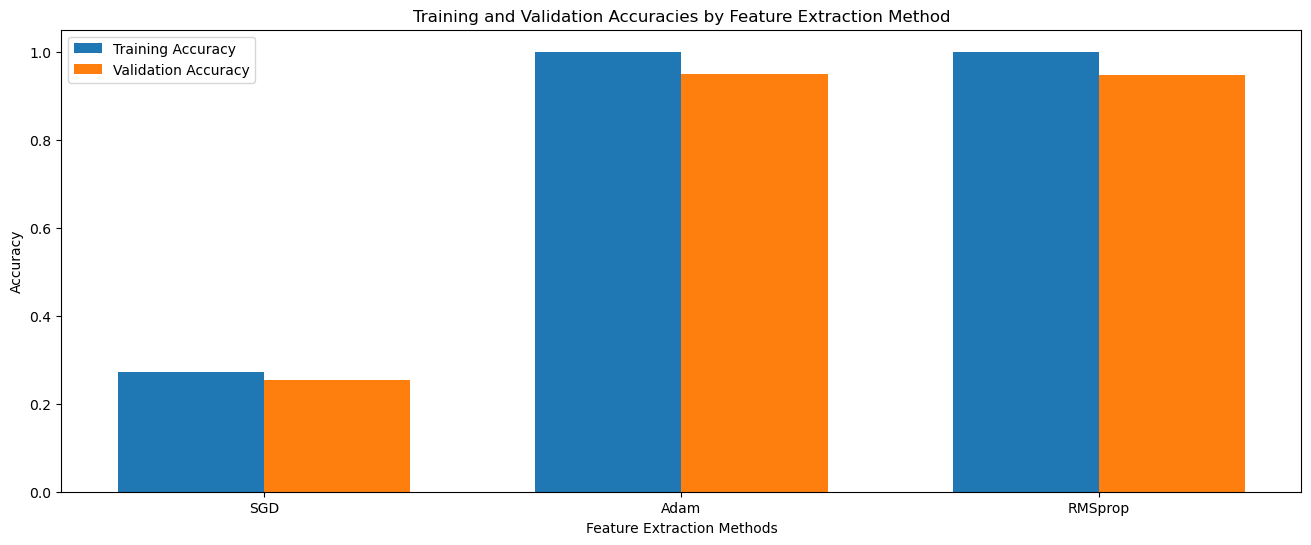

In [31]:

parameters = ['SGD', 'Adam', 'RMSprop']
train_acc = result_opt_df['Training_Accuracy'].tolist()
val_acc = result_opt_df['Validation_Accuracy'].tolist()
# train_acc = [np.mean(Train_acc_count), np.mean(Train_acc_tfidf),np.mean(Train_acc_bert), np.mean(Train_acc_Glove)]
# val_acc = [np.mean(Val_acc_count), np.mean(Val_acc_tfidf),np.mean(Val_acc_bert), np.mean(Val_acc_Glove)]

width = 0.35
x = np.arange(len(parameters))
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, train_acc, width, label='Training Accuracy')
ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')
ax.set_xlabel('Feature Extraction Methods')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracies by Feature Extraction Method')
ax.set_xticks(x)
ax.set_xticklabels(parameters)
ax.legend()
plt.show()

In [32]:
y_train_one_hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [33]:
values = result_df['Avg_Val_Acc']
print(values)
keys = result_df['Feature']
lis = [(values[i], keys[i]) for i in range(3)]
lis.sort(reverse = True)
ans = lis[0][1]
feature = np.array(data[ans].tolist()) 

0    0.946
1    0.951
2    0.937
3    0.968
Name: Avg_Val_Acc, dtype: float64


**Select model parameters with best accuracies using GridSearch**

In [34]:
# !pip install keras-tuner

X_train, X_valid, Y_train, Y_valid = train_test_split(feature, y_train_one_hot, test_size=0.2, random_state=42)

def createModel(input_dim):
    input_text = Input(shape=(input_dim,))
    hidden1 = Dense(128, activation='relu')(input_text)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(num_classes, activation='softmax')(hidden2)
    model = Model(inputs=input_text, outputs=output)
    return model

def build_model(hp):
    model = createModel(feature.shape[1])
    hp_optimizer = hp.Choice('optimizer', ['SGD', 'Adam', 'RMSprop'])
    hp_learning_rate = hp.Choice('learning_rate', [ 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2])

    if hp_optimizer == 'Adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'SGD':
        optimizer = SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize tuner
tuner = GridSearch(
    build_model,
    tune_new_entries=True,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=5
)

# Start the search for best hyperparameters
tuner.search(X_train, Y_train,
             epochs=10,
             validation_data=(X_valid, Y_valid))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
#print(f"Best Hyperparameters: {best_hps.values}")
print(f"Best Hyperparameters: {best_hps}")

Reloading Tuner from ./untitled_project/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x2dc9a5610>


In [35]:
best_trials = tuner.oracle.get_best_trials(num_trials=2)

for trial in best_trials:
    print("Hyperparameters:", trial.hyperparameters.values)

Hyperparameters: {'optimizer': 'RMSprop', 'learning_rate': 0.003}
Hyperparameters: {'optimizer': 'RMSprop', 'learning_rate': 0.001}


**Train and Validate the chosen model to predict labels for test data**

In [36]:
# data = pd.read_csv('news-test.csv')
Y = data['Category']
X_train, X_valid, Y_train, Y_valid = train_test_split(feature, Y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(Y_train)
y_val_encoded = label_encoder.transform(Y_valid)
Y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
Y_val_one_hot = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))


best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train, Y_train_one_hot, epochs=10)
predictions = best_model.predict(X_valid)
y_pred = np.argmax(predictions, axis=1)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Calculate metrics
accuracy = accuracy_score(Y_valid, y_pred_decoded)
precision = precision_score(Y_valid, y_pred_decoded, average='weighted')
recall = recall_score(Y_valid, y_pred_decoded, average='weighted')
f1 = f1_score(Y_valid, y_pred_decoded, average='weighted')
conf_matrix = confusion_matrix(Y_valid, y_pred_decoded)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10
25/25 [==============================] - 0s 847us/step - loss: 2.9655e-04 - accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 0s 681us/step - loss: 2.3009e-04 - accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 0s 702us/step - loss: 1.9003e-04 - accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 0s 692us/step - loss: 1.6037e-04 - accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 0s 719us/step - loss: 1.3558e-04 - accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 0s 701us/step - loss: 1.2232e-04 - accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 0s 677us/step - loss: 1.0827e-04 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 0s 725us/step - loss: 9.6157e-05 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 0s 684us/step - loss: 8.7159e-05 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 0s 496us/step

In [37]:
feature_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.31905342, 0.        ,
        0.        ]])

In [38]:

predictions = best_model.predict(feature_test)
y_pred = np.argmax(predictions, axis=1)
y_train_decoded = label_encoder.inverse_transform(y_pred)
test['predictedLabel'] = y_train_decoded
test[['ArticleId', 'predictedLabel']].to_csv("labels.csv", header=False, index=False)

23/23 [==============================] - 0s 327us/step
